In [70]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup

imp.reload(sp)

mbins = 100

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [3]:
z_l, dndz_l, zleff = sp.zed.get_dndz_spec(gtype='lens')
rp = setup.arcmin_to_rp(20, zleff, sp.zed.cosmo_SRD) * (sp.pa.HH0 / 100.)
theta_edges = setup.setup_rp_bins(0.2, 25, 10)
theta_cents = setup.rp_bins_mid(theta_edges)
print(theta_cents)
print(rp)

[ 0.25461002  0.41263541  0.6687403   1.08379839  1.756465    2.8466266
  4.61340417  7.47674391 12.11723433 19.63787576]
10.138759220905907


## We start with the case where there is no Intrinsic Alignment

First get F($\theta$) using dependance from Sara $\Pi_{close} = r_{p} ; r_{p} > 2 : \Pi_{close} = 2Mpch^{-1} ; r_{p} \leq 2Mpch^{-1}$

In [9]:
F = sp.get_F(theta_dependence=False)
F_theta = sp.get_F(theta_dependence=True)

Check values of F are sensible for both cases. 
We would expect F without theta dependence to be much larger across these scales becuase the projection is 100Mpc h-1, whereas the max projection with theta depedence is ~ 10Mpc h-1

In [5]:
print(F)
print(F_theta)

0.02073898968122842
[0.0006165  0.0006165  0.0006165  0.0006165  0.0006165  0.0006165
 0.00080148 0.00129893 0.00210512 0.00341169]


Next calculate $B(\theta) - 1$ (or load from boost file, comment out accordingly)

In [12]:
#B_min1, theta = sp.get_boosts()
B_min1 = np.load('generated_data/Boost_data_year1.npz')['B_min1']
theta = np.load('generated_data/Boost_data_year1.npz')['theta']

In [13]:
print(B_min1)
print(theta)

[0.09429856 0.05354952 0.03250654 0.02241816 0.0159059  0.01095674
 0.00716792 0.00437449 0.00244329 0.00122134]
[ 0.25461002  0.41263541  0.6687403   1.08379839  1.756465    2.8466266
  4.61340417  7.47674391 12.11723433 19.63787576]


For LSST we have the multiplicative bias requirements:

Y1 $\Delta m \leq 0.013$

Y10 $\Delta m \leq 0.003$

In [14]:
# year 1 mbias
delM_max = 0.013
# year 10 mbias
#delM = 0.013

delM_minus_delMp = np.linspace(-2.*delM_max, +2.*delM_max, mbins)

#### Next get $\gamma_{t}$ for a range of $\Delta m$

Assumptions:
- Define scale factors in gM power spectrum as lens scale factors

In [24]:
ell = np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 180/(theta[0]/60.) + 10, 1024).astype(int))

# compute angular power spectrum for galaxy-galaxy lensing
Cl_gM, tracer1, tracer2 = sp.get_LSST_Cl(ell, 'gm')

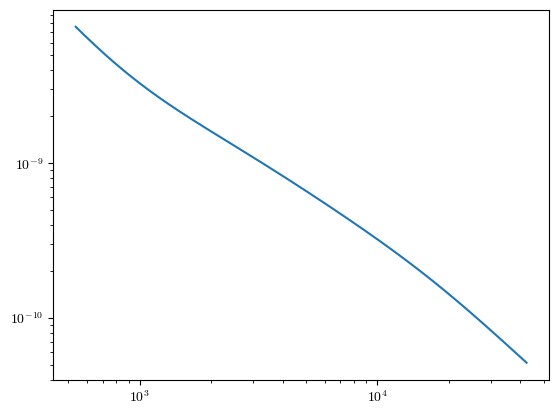

In [25]:
plt.loglog(ell, Cl_gM)

In [27]:
gammat = sp.get_gammat_noIA(Cl_gM, theta, ell)

### Now we combine everything on the LHS to get RHS for different combinations of $\Delta m$
$\frac{\tilde{\gamma}_{t} - \tilde{\gamma}_{t}^{\prime}}{B(\theta) - 1 + F} = 
    (\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}(\theta)$
    
IA acts radially so detracts from lensing signal. Therefore we take most from least contaminated

In [28]:
delM_yL_PA = np.zeros([mbins, len(theta)])  
for i in range(mbins):
        delM_yL_PA[i,:] = delM_minus_delMp[i] * (gammat /  (B_min1 + F_theta))

In [ ]:
print(B_min1 + F)

The rows correspond to bias on gammat, the columns gammat_prime and the 3rd dim is the values for different theta

In [ ]:
def plot(m):
    
    plt.figure(figsize=[8,6])
    plt.plot(theta, delM_yL_PA[m,:], linewidth=0, marker='o')
    plt.plot(theta, gammat, linewidth=0, marker='s')
    plt.title(r'$\delta m - \delta m^{\prime} = %g$'%delM_minus_delMp[m])
    plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend([r'$(\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}(\theta)$',
                r'$\bar{\gamma}_{t}$', r'$\bar{\gamma}_{t}^{\prime}$'],fontsize=14)
    
interactive_plot = interactive(plot, m=(0,mbins-1))
interactive_plot

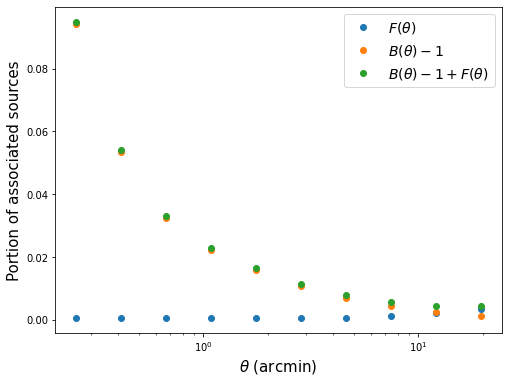

In [116]:
plt.figure(figsize=[8,6])
plt.plot(theta, F_theta, linewidth=0, marker='o')
plt.plot(theta, B_min1, linewidth=0, marker='o')
plt.plot(theta, B_min1 + F_theta, linewidth=0, marker='o')
plt.ylabel(r'Portion of associated sources', fontsize=15)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.xscale('log')
plt.legend([r'$F(\theta)$', r'$B(\theta) - 1$', 
            r'$B(\theta) - 1 + F(\theta)$'], fontsize=14);

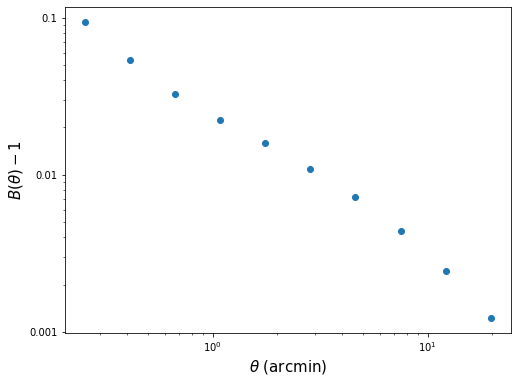

In [117]:
plt.figure(figsize=[8,6])
plt.plot(theta, B_min1, linewidth=0, marker='o')
plt.ylabel(r'$B(\theta) - 1$', fontsize=15)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.yticks([1E-1,1E-2,1E-3], ['0.1','0.01','0.001']);

### Lets try some theortetical IA modelling with CCL
- Take $\bar{A}_{IA} = 5.$ and $\sigma_{A} = 3.9$ from SRD
- $f_{red} = 0.16$ from L2018
- A should be a function of redshift, but for now we will assume it is unrealted to the redshift (DISCUSS WITH DANIELLE)
- Let's assume a pessimistic a = 0.65 (Singh 2016)

In [29]:
z_l, dndz_l, zleff = sp.zed.get_dndz_spec('source')
z_s, dndz_s, zseff = sp.zed.get_dndz_spec('lens')

A_IA = 5. * np.ones(len(z_l))

lensTracer = ccl.NumberCountsTracer(sp.halo.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                    bias=(z_l, sp.lens_bias(z_l)))
intrinsicTracer = ccl.WeakLensingTracer(sp.halo.cosmo_SRD, (z_s, dndz_s), has_shear=False, 
                                     ia_bias=(z_s, A_IA))

In [30]:
# defined to be same as in boost function
k_arr = np.geomspace(1E-4, 5E2, 3000)

a_l = 1. / (1. + z_l)

# create 2D power spectrum objects for galaxy-IA correlation
pk_gMf = sp.halo.get_Pk2D('gm', k_arr, np.flip(a_l))

# compute aps for galaxy-intrinsicshape
Cl_IA = ccl.angular_cl(sp.halo.cosmo_SRD, lensTracer, intrinsicTracer, ell, p_of_k_a=pk_gMf)

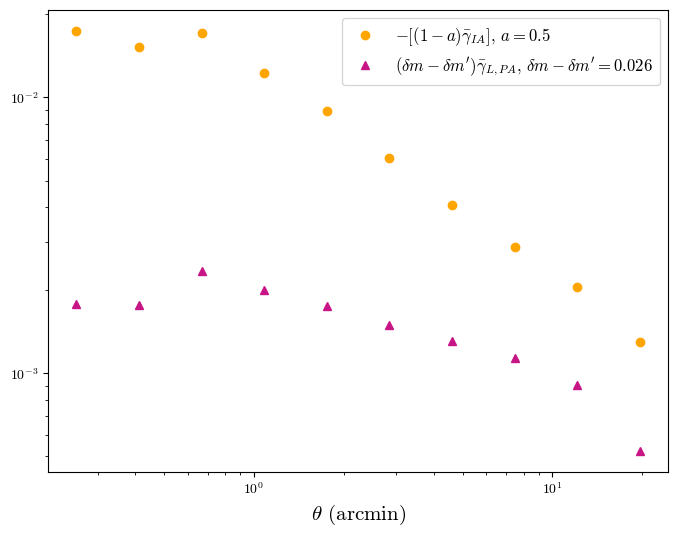

In [31]:
y_IA = ccl.correlation(sp.halo.cosmo_SRD, ell, Cl_IA, theta / 60., type='NG')
bar_yIA = y_IA / (B_min1 + F)

a = 0.5
yIA_1mina = (1.-a)*bar_yIA

plt.figure(figsize=[8,6])
plt.plot(theta, -yIA_1mina, linewidth=0, marker='o', color='orange')
plt.plot(theta, delM_yL_PA[99,:], linewidth=0, marker='^', color='mediumvioletred')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([1E-5, 1E-1])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.legend([r'$-[(1-a)\bar{\gamma}_{IA}]$, $a=%g$'%a, 
            r'$(\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}$, $\delta m - \delta m^{\prime} = %g$'%delM_minus_delMp[99]], 
           fontsize=12)
plt.savefig('IA_vs_artefact_forecast_prelim.png', dpi=300)

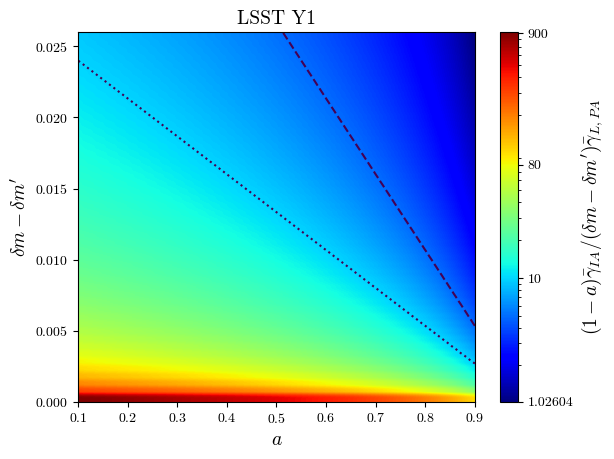

In [58]:
a_off = np.linspace(0.1, 0.9, 1000)

yIA_of_a = np.zeros([len(a_off),len(bar_yIA)])
for i in range(len(a_off)):
    yIA_of_a[i,:] = (1.-a_off[i])*bar_yIA
    
SNR = np.zeros([len(delM_minus_delMp),len(a_off)])
for i in range(len(a_off)):
    for j in range(len(delM_minus_delMp)):
        SNR[j,i] = abs(np.mean(yIA_of_a[i,:] / delM_yL_PA[j,:]))

A,M = np.meshgrid(a_off,delM_minus_delMp)        
        
fig, ax = plt.subplots()
cax = ax.imshow(SNR, extent=[a_off[0],a_off[-1],delM_minus_delMp[0],delM_minus_delMp[-1]], aspect='auto', 
           norm=mpl.colors.LogNorm(), cmap='jet')

snr10 = ax.contour(A,M,SNR,[10],linestyles='dotted')
snr5 = ax.contour(A,M,SNR,[5], linestyles='--')

cbar = fig.colorbar(cax, ticks=[SNR.min(),10,80,900])
cbar.ax.set_yticklabels(['%g'%SNR.min(),'10','80','900']);
cbar.set_label(r'$(1-a)\bar{\gamma}_{IA}/(\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}$', fontsize=14)
plt.xlabel(r'$a$', fontsize=14)
plt.ylabel(r'$\delta m - \delta m^{\prime}$', fontsize=14)
plt.ylim([0,0.026])
plt.title('LSST Y1', fontsize=14)
plt.savefig('SNR_colorbar.png',dpi=300)

In [69]:
print(delM_minus_delMp[99], a_off[516], SNR[99,516])

0.026 0.5132132132132132 4.9946057784177365


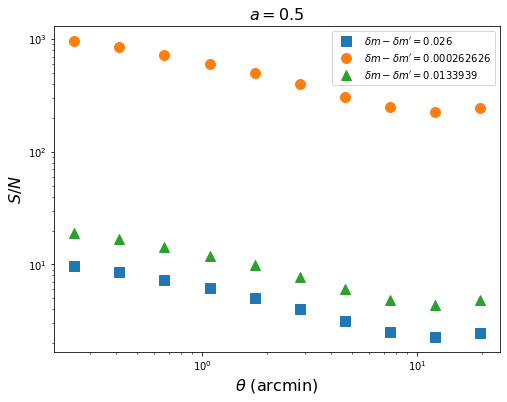

In [177]:
plt.figure(figsize=[8,6])

SNR_min = -yIA_1mina / delM_yL_PA[99,:]
SNR_max = -yIA_1mina / delM_yL_PA[50,:]
SNR_mid = -yIA_1mina / delM_yL_PA[75,:]

plt.plot(theta, SNR_min, linewidth=0, marker='s', markersize=10)
plt.plot(theta, SNR_max, linewidth=0, marker='o', markersize=10)
plt.plot(theta, SNR_mid, linewidth=0, marker='^', markersize=10)
        
plt.ylabel(r'$S/N$', fontsize=16)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=16)
plt.title(r'$a = %g$'%a, fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\delta m - \delta m^{\prime} = %g$'%(delM_minus_delMp[99]), 
            r'$\delta m - \delta m^{\prime} = %g$'%(delM_minus_delMp[50]), 
            r'$\delta m - \delta m^{\prime} = %g$'%(delM_minus_delMp[75])],
          fontsize=10)
plt.savefig('superduperpreliminary.png', dpi=300)

## $\bar{\gamma}_{IA}$ covaraince calculation

- We will use $\sigma_{y} = \sigma_{y}^{\prime}$
- We will only compute statistical covariance as this was found to be dominant in the L2018 method with systematics at only 1% of total error


In [ ]:
import tjpcov

In [ ]:
rho = 0.5 

tjpcov.cov_calc = tjpcov.CovarianceCalculator(cosmo_fn=sp.halo.cosmo, 
                                       sacc_cl_fn=sp.get_LSST_Cl(LSST_year, ell, 'gg'))

In [ ]:
sig_IA = np.sqrt(np.diag(cov_mat_stat))

def plot(ma, mb):
    
    plt.figure(figsize=[8,6])
    plt.errorbar(theta, -bar_yIA, y_err=sig_IA, linewidth=0, marker='o', color='orange')
    plt.plot(theta, yL_PA[ma,mb,:], linewidth=0, marker='o', color='mediumvioletred')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
    plt.legend([r'$(1-a)\bar{\gamma}_{IA}$, $a=%g$'%a, 
                r'$(\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}$, $\delta m = %g$, $\delta m^{\prime} = %g$'%(delM[ma], -delM[mb])], 
               fontsize=14)
    
interactive_plot = interactive(plot, ma=(range(mbins)), mb=(range(mbins))
interactive_plot